In [1]:
#import my data
import pandas as pd
player = pd.read_csv('C:/Users/Jake/Jake_Dennis_DS-Unit-2-Applied-Modeling/data/Player.csv')
player_atr = pd.read_csv('C:/Users/Jake/Jake_Dennis_DS-Unit-2-Applied-Modeling/data/Player_Attributes.csv')

In [2]:
#merge the dataframes
df = pd.merge(player, player_atr, on='id')
#drop duplicate columns
dropped = ['player_fifa_api_id_y', 'player_api_id_y']
df = df.drop(columns=dropped)

In [3]:
#rename columns
df = df.rename(columns={'player_api_id_x':'player_api_id', 'player_fifa_api_id_x':'player_fifa_api_id'})
pd.set_option('display.max_columns', 999)

In [4]:
#change to datetime type
df['date'] = pd.to_datetime(df['date'])
df['birthday'] = pd.to_datetime(df['birthday'])

In [7]:
#engineer age feature
from datetime import timedelta
df['age'] = df['date']-df['birthday']
df['age'] = df["age"] / timedelta(days=365)
df['age'] = pd.to_numeric(df['age'])
df['age'] = df['age'].astype(int)

In [8]:
#drop nulls
df = df.dropna()

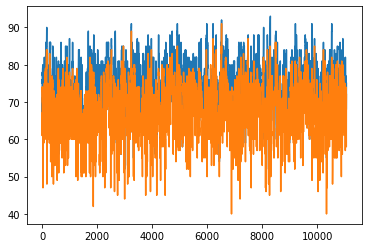

In [9]:
from matplotlib import pyplot as plt
plt.plot(df['potential'])
plt.plot(df['overall_rating'])
plt.show()

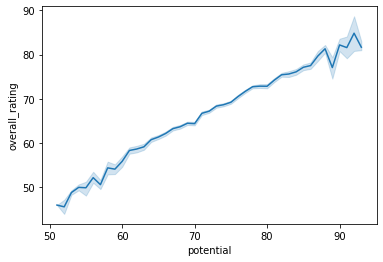

In [10]:
import seaborn as sns
sns.lineplot(df['potential'], df['overall_rating']);

In [ ]:
#looks like the potential column could have some leakage with our target

In [11]:
#split into train, val, and test
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, random_state=42)
train, val = train_test_split(train, train_size=.2, random_state=42)
thefeatures = train.drop(columns=['id', 'player_api_id', 'player_name', 'player_fifa_api_id', 
                                  'birthday','date','overall_rating', 'preferred_foot', 'attacking_work_rate', 
                                  'defensive_work_rate', 'potential'])
features = thefeatures.columns.tolist()
target = 'overall_rating'
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [23]:
#baseline error for train
from sklearn.metrics import mean_absolute_error
guess = y_train.mean()
y_pred = [guess] * len(y_train)
mae = mean_absolute_error(y_train, y_pred)
print(f'Train Error For Fifa Ratings Overall: {mae:.2f} points')

Train Error For Fifa Ratings Overall: 5.79 points


In [24]:
#Does Linear Regression beat baseline?
from sklearn.linear_model import LinearRegression
LR = LinearRegression()
LR.fit(X_train, y_train)
y_pred = LR.predict(X_train)
mae = mean_absolute_error(y_train, y_pred)
print(f'Train Error: {mae:.2f} points')

Train Error: 2.42 points


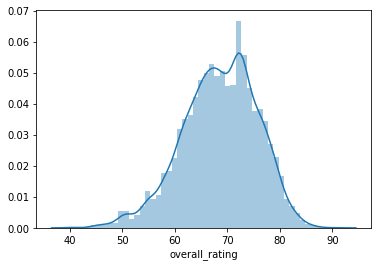

In [16]:
sns.distplot(df['overall_rating']);

In [18]:
#find what features are important to a forest model
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

permuter = PermutationImportance(model, scoring='neg_mean_squared_error', cv='prefit', 
                                 n_iter=3, random_state=42)

permuter.fit(X_train, y_train)
feature_names = X_train.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

E:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
E:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


Weight,Feature
15.2719 ± 0.6760,reactions
11.4820 ± 0.2659,ball_control
3.6096 ± 0.0765,standing_tackle
1.9988 ± 0.1043,marking
1.3085 ± 0.1138,gk_diving
1.1251 ± 0.0783,dribbling
1.0536 ± 0.0997,strength
1.0305 ± 0.0666,shot_power
0.9977 ± 0.1107,heading_accuracy
0.7502 ± 0.0493,finishing


In [19]:
#Make a dataframe of the elie_weights importances:
eli_importances_df = eli5.explain_weights_df(permuter, feature_names=feature_names)

#inspect the 20 features w/ least importance
eli_importances_df.sort_values(by='weight', ascending=False).tail(20)

,feature,weight,std
16,stamina,0.172509,0.002532
17,vision,0.155169,0.010460
18,sliding_tackle,0.148998,0.010307
19,long_shots,0.148962,0.002838
20,interceptions,0.145465,0.004644
21,jumping,0.129089,0.008120
22,free_kick_accuracy,0.115075,0.005162
23,gk_positioning,0.109852,0.004030
24,sprint_speed,0.109580,0.003004
25,aggression,0.105156,0.002794


In [ ]:
#Reactions (Attribute) Reactions is a Player Attribute in FIFA that determines the acting speed of a player in response to the situations happening around them.

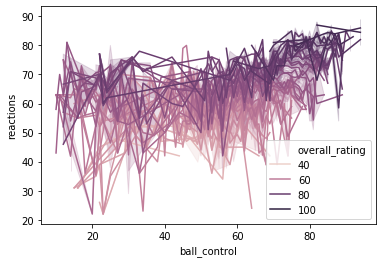

In [17]:
sns.lineplot(x="ball_control", y="reactions",
             hue="overall_rating",
             data=df);

In [25]:
#train error using forest model
y_pred = model.predict(X_train)
mae = mean_absolute_error(y_train, y_pred)
print(f'Train Error: {mae:.2f} points')

Train Error: 0.46 points


In [21]:
#pdp graph with the 2 most important features
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['ball_control', 'reactions']

interaction = pdp_interact(
    model=model,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

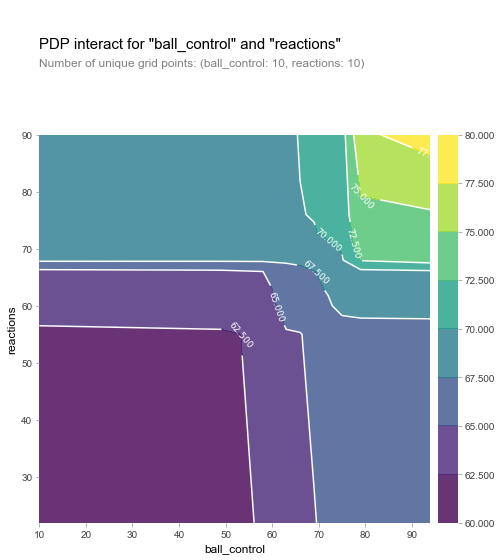

In [22]:
pdp_interact_plot(interaction, plot_type='contour', feature_names=features);

In [26]:
from pdpbox.pdp import pdp_isolate, pdp_plot
feature = 'reactions'

isolated = pdp_isolate(
    model=model,
    dataset=X_val,
    model_features=X_val.columns,
    feature=feature
)

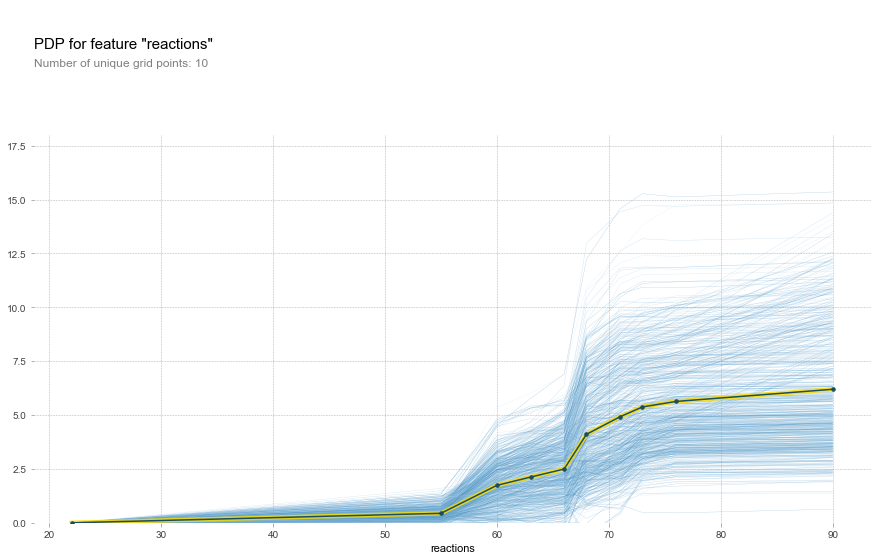

In [27]:
pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=0.1);